# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': None,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 100,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': False,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 100,
                
        'interpretation_net_output_monomials': 3, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': -3,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable

from joblib import Parallel, delayed
import dill as pickle

Parallel.pickle = pickle
delayed.pickle = pickle

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex, clear_output


In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

from symbolic_metamodeling.pysymbolic.algorithms.symbolic_metamodeling import * 


In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_21_drop0.25e500b256_custom/lnets_100_30-1000e64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xdist_uniform_noise_normal_0
lnets_100_30-1000e64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_1_d_5_sparsity_6_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

100%|██████████| 6/6 [00:00<00:00, 52980.68it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']
List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   4 out of  11 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-3)]: Done   8 out of  11 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-3)]: Done  11 out of  11 | elapsed:    0.6s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
83,1373158606,0.949,0.972,0.396,0.072,-0.381,0.628,0.927,0.716,4.863,-16.066,20.996,-8.889,0.949,0.972,0.396,0.072,-0.381,0.628,-0.009,-0.227,0.131,0.083,0.411,0.349,0.110,-0.297,0.066,0.439,1.013,-0.088,-0.019,0.131,0.346,0.175,0.211,0.461,0.496,0.475,0.261,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,0.208,0.208,-0.110,0.000,-0.070,0.173,-0.657,0.000,0.000,-0.131,0.209,-0.175,0.209,0.211,0.207,0.209,0.219,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.225,0.409,0.441,-0.042,-0.408,-0.258,0.170,1.119,-0.352,-0.364,-0.041,0.377,-0.082,0.622,0.293,0.446,0.331,0.291,-0.309,-0.045,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.211
53,1373158606,-0.687,-0.500,0.098,0.429,0.320,-0.440,-0.687,-0.475,-0.110,1.076,-0.493,-0.086,-0.687,-0.500,0.098,0.429,0.320,-0.440,-0.009,-0.227,0.253,0.143,0.342,0.274,0.194,-0.297,0.109,0.218,0.372,-0.088,-0.019,0.246,0.272,0.362,0.008,0.407,0.344,0.417,0.034,0.055,-0.074,-0.042,-0.404,-0.090,0.069,-0.291,-0.209,-0.233,0.000,0.000,0.159,0.162,-0.130,-0.159,0.164,0.000,0.164,0.174,0.157,0.000,0.000,0.161,-0.186,0.157,-0.023,-0.195,-0.050,-0.114,-0.039,0.166,0.215,0.000,0.000,0.000,0.164,0.000,0.000,0.000,-0.254,-0.359,-0.332,-0.353,0.380,0.446,-0.185,-0.408,-0.390,-0.073,-0.185,-0.352,-0.364,-0.193,0.398,-0.262,0.394,0.332,0.244,0.277,0.049,-0.458,-0.266,-0.261,-0.383,-0.059,-0.477,0.144,-0.258,-0.315,-0.158
70,1373158606,0.583,0.579,-0.818,-0.011,-0.885,0.099,0.584,0.582,-0.856,0.124,-1.068,0.183,0.583,0.579,-0.818,-0.011,-0.885,0.099,-0.009,-0.227,0.505,0.444,0.239,0.174,0.540,-0.297,0.430,0.662,0.631,-0.088,-0.019,0.554,0.163,0.588,0.032,0.273,0.334,0.299,0.030,0.416,0.012,-0.042,-0.404,-0.090,0.412,-0.291,-0.209,-0.233,0.000,0.000,-0.243,-0.320,0.158,0.161,-0.351,0.000,-0.342,-0.096,-0.242,0.000,0.000,-0.315,0.164,-0.161,0.165,0.162,0.154,0.157,0.195,-0.357,-0.020,0.000,0.000,0.000,-0.384,0.000,0.000,0.000,-0.254,-0.359,-0.720,-1.026,0.324,0.373,-0.820,-0.408,-1.191,-0.391,-0.503,-0.352,-0.364,-0.703,0.310,-0.490,0.607,0.198,0.343,0.232,0.259,-1.388,-0.047,-0.261,-0.383,-0.059,-1.474,0.144,-0.258,-0.315,0.153
45,1373158606,0.619,0.620,0.734,0.826,0.023,0.003,0.592,1.068,-1.169,3.838,-1.662,0.147,0.619,0.620,0.734,0.826,0.023,0.003,-0.009,-0.227,0.131,0.083,0.402,0.339,0.110,-0.297,0.068,1.272,1.112,-0.088,-0.019,0.131,0.339,0.178,0.195,0.462,0.486,0.472,0.260,0.041,0.009,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,0.147,0.149,-0.110,0.000,-0.069,-0.495,-0.792,0.000,0.000,-0.131,0.145,-0.178,0.158,0.134,0.149,0.139,0.137,-0.048,-0.022,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.200,-0.226,0.368,0.397,-0.043,-0.408,-0.258,0.951,1.386,-0.352,-0.364,-0.043,0.331,-0.095,0.565,0.251,0.408,0.290,0.233,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.173
44,1373158606,0.755,0.482,0.394,0.405,-0.281,-0.413,0.709,0.782,0.458,-2.054,3.647,-2.208,0.755,0.482,0.394,0.405,-0.281,-0.413,-0.009,-0.227,0.367,0.356,0.338,0.276,0.397,-0.297,0.067,0.339,0.247,-0.088,-0.019,0.378,0.272,0.280,0.137,0.385,0.425,0.402,0.180,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.277,-0.337,0.181,0.181,-0

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
mean,1373158606.000,0.012,0.130,0.010,0.011,-0.046,-0.080,0.013,0.102,0.249,-0.666,0.725,-0.387,0.012,0.130,0.010,0.011,-0.046,-0.080,-0.009,-0.227,0.298,0.207,0.292,0.241,0.335,-0.297,0.175,0.530,0.469,-0.088,-0.019,0.359,0.251,0.389,0.103,0.485,0.374,0.422,0.179,0.131,0.068,-0.042,-0.404,-0.090,0.138,-0.291,-0.209,-0.233,0.000,0.000,-0.036,-0.048,0.002,-0.020,-0.134,0.000,-0.050,-0.203,-0.068,0.000,0.000,-0.100,-0.041,-0.008,0.007,-0.132,0.038,-0.043,-0.028,-0.050,-0.032,0.000,0.000,0.000,-0.047,0.000,0.000,0.000,-0.254,-0.359,-0.415,-0.495,0.344,0.444,-0.224,-0.408,-0.561,0.062,-0.101,-0.352,-0.364,-0.241,0.425,-0.281,0.670,0.043,0.321,0.103,0.353,-0.675,-0.363,-0.261,-0.383,-0.059,-0.680,0.144,-0.258,-0.315,0.004
std,0.000,0.597,0.577,0.616,0.573,0.613,0.596,0.592,0.717,2.963,9.465,12.014,4.976,0.597,0.577,0.616,0.573,0.613,0.596,0.000,0.000,0.173,0.189,0.168,0.181,0.251,0.000,0.194,0.388,0.218,0.000,0.000,0.212,0.199,0.162,0.177,0.294,0.159,0.216,0.229,0.201,0.266,0.000,0.000,0.000,0.196,0.000,0.000,0.000,0.000,0.000,0.175,0.192,0.171,0.206,0.258,0.000,0.204,0.352,0.204,0.000,0.000,0.225,0.231,0.145,0.201,0.325,0.129,0.231,0.243,0.219,0.247,0.000,0.000,0.000,0.211,0.000,0.000,0.000,0.000,0.000,0.249,0.366,0.235,0.349,0.709,0.000,0.453,0.708,0.401,0.000,0.000,0.539,0.440,0.168,0.472,0.685,0.182,0.576,0.455,0.593,0.571,0.000,0.000,0.000,0.557,0.000,0.000,0.000,0.173
min,1373158606.000,-0.989,-0.982,-0.986,-0.967,-0.990,-0.978,-0.992,-1.957,-10.101,-44.392,-45.504,-25.911,-0.989,-0.982,-0.986,-0.967,-0.990,-0.978,-0.009,-0.227,-0.124,-0.209,-0.056,-0.131,-0.109,-0.297,-0.238,-0.724,0.004,-0.088,-0.019,-0.051,-0.144,0.048,-0.239,-0.043,0.048,0.009,-0.266,-0.280,-0.406,-0.042,-0.404,-0.090,-0.268,-0.291,-0.209,-0.233,0.000,0.000,-0.421,-0.427,-0.417,-0.567,-0.825,0.000,-0.500,-1.119,-0.912,0.000,0.000,-0.665,-0.607,-0.336,-0.572,-1.013,-0.294,-0.869,-0.655,-0.572,-0.712,0.000,0.000,0.000,-0.604,0.000,0.000,0.000,-0.254,-0.359,-1.106,-1.495,-0.001,-0.000,-1.507,-0.408,-1.854,-1.767,-0.755,-0.352,-0.364,-1.230,-0.374,-0.735,0.183,-1.875,-0.728,-2.433,-0.834,-2.336,-2.084,-0.261,-0.383,-0.059,-2.649,0.144,-0.258,-0.315,-0.295
25%,1373158606.000,-0.434,-0.357,-0.529,-0.513,-0.621,-0.609,-0.431,-0.440,-0.675,-1.213,-0.999,-0.648,-0.434,-0.357,-0.529,-0.513,-0.621,-0.609,-0.009,-0.227,0.141,0.082,0.128,

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.62554346],
       [0.19556352],
       [0.24448189],
       [0.93211286],
       [0.5878022 ],
       [0.01096125],
       [0.24066001],
       [0.88099432],
       [0.93313289],
       [0.76824799]])

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[1.73161822],
       [1.15427949],
       [1.21046001],
       [2.41202533],
       [1.67053915],
       [0.95949628],
       [1.20600159],
       [2.26604811],
       [2.41512409],
       [1.99774864]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(81, 110)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(9, 110)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(10, 110)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
10,1373158606,-0.223,-0.457,0.657,-0.286,-0.438,0.085,-0.223,-0.438,0.543,-0.015,-0.705,0.178,-0.223,-0.457,0.657,-0.286,-0.438,0.085,-0.009,-0.227,0.317,0.210,0.262,0.184,0.249,-0.297,0.179,0.491,0.425,-0.088,-0.019,0.301,0.166,0.421,0.008,0.259,0.315,0.299,0.526,0.129,-0.312,-0.042,-0.404,-0.090,0.142,-0.291,-0.209,-0.233,0.000,0.000,0.043,0.042,-0.019,-0.045,0.021,0.000,0.043,-0.347,0.030,0.000,0.000,0.027,-0.045,0.040,-0.023,-0.054,-0.038,-0.053,-0.456,0.044,0.170,0.000,0.000,0.000,0.046,0.000,0.000,0.000,-0.254,-0.359,-0.290,-0.266,0.189,0.159,-0.123,-0.408,-0.282,-0.657,-0.170,-0.352,-0.364,-0.148,0.082,-0.245,0.394,0.074,0.211,0.124,-0.834,-0.307,-0.450,-0.261,-0.383,-0.059,-0.338,0.144,-0.258,-0.315,-0.061
98,1373158606,-0.744,-0.696,-0.722,0.282,-0.636,-0.309,-0.715,-1.125,0.991,-2.235,0.622,-0.354,-0.744,-0.696,-0.722,0.282,-0.636,-0.309,-0.009,-0.227,0.367,0.261,0.109,0.081,0.315,-0.297,0.230,0.367,0.484,-0.088,-0.019,0.362,0.079,0.473,0.008,1.145,0.145,0.944,0.033,0.179,0.109,-0.042,-0.404,-0.090,0.192,-0.291,-0.209,-0.233,0.000,0.000,0.158,0.158,-0.109,-0.082,0.147,0.000,0.159,0.126,0.148,0.000,0.000,0.148,-0.080,0.154,-0.023,-0.872,-0.145,-0.423,-0.040,0.161,0.147,0.000,0.000,0.000,0.162,0.000,0.000,0.000,-0.254,-0.359,-0.392,-0.386,0.139,0.187,-0.231,-0.408,-0.410,-0.122,-0.258,-0.352,-0.364,-0.250,0.122,-0.335,0.393,-1.749,0.143,-1.075,0.049,-0.450,-0.176,-0.261,-0.383,-0.059,-0.477,0.144,-0.258,-0.315,-0.176
31,1373158606,0.634,0.110,0.059,-0.516,-0.814,0.794,0.635,0.081,0.294,-1.195,0.013,0.439,0.634,0.110,0.059,-0.516,-0.814,0.794,-0.009,-0.227,0.333,0.272,0.164,0.100,0.352,-0.297,0.249,-0.032,0.477,-0.088,-0.019,0.381,0.088,0.397,-0.046,0.196,0.257,0.223,-0.055,0.210,0.008,-0.042,-0.404,-0.090,0.215,-0.291,-0.209,-0.233,0.000,0.000,-0.095,-0.137,0.182,0.184,-0.153,0.000,-0.141,-0.000,-0.006,0.000,0.000,-0.140,0.189,-0.073,0.190,0.186,0.177,0.181,0.225,-0.150,-0.023,0.000,0.000,0.000,-0.138,0.000,0.000,0.000,-0.254,-0.359,-0.323,-0.461,0.279,0.335,-0.323,-0.408,-0.522,-0.004,-0.218,-0.352,-0.364,-0.296,0.275,-0.203,0.629,0.153,0.293,0.185,0.273,-0.539,-0.044,-0.261,-0.383,-0.059,-0.572,0.144,-0.258,-0.315,0.174
81,1373158606,-0.909,-0.438,0.901,0.781,-0.089,0.240,-0.908,-0.444,0.903,0.787,-0.068,0.216,-0.909,-0.438,0.901,0.781,-0.089,0.240,-0.009,-0.227,0.189,0.071,0.597,0.547,0.120,-0.297,0.037,0.136,0.315,-0.088,-0.019,0.177,0.555,0.304,0.445,0.682,0.612,0.682,0.552,-0.018,-0.137,-0.042,-0.404,-0.090,-0.003,-0.291,-0.209,-0.233,0.000,0.000,0.181,0.191,-0.247,-0.351,0.192,0.000,0.193,0.215,0.169,0.000,0.000,0.183,-0.412,0.173,-0.411,-0.363,-0.092,-0.195,-0.460,0.197,0.250,0.000,0.000,0.000,0.195,0.000,0.000,0.000,-0.254,-0.359,-0.373,-0.431,0.792,1.095,-0.244,-0.408,-0.475,-0.124,-0.192,-0.352,-0.364,-0.235,1.126,-0.272,1.621,0.791,0.591,0.621,1.279,-0.545,-0.303,-0.261,-0.383,-0.059,-0.566,0.144,-0.258,-0.315,-0.181
41,1373158606,-0.144,0.933,0.927,0.706,-0.411,-0.230,-0.144,0.937,0.900,0.798,-0.536,-0.174,-0.144,0.933,0.927,0.706,-0.411,-0.230,-0.009,-0.227,0.136,0.085,0.603,0.450,0.114,-0.297,0.069,0.683,0.379,-0.088,-0.019,0.269,0.481,0.292,0.309,0.619,0.686,0.695,0.402,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
69,1373158606,0.264,-0.103,-0.414,-0.343,0.345,0.505,0.265,-0.158,0.002,-1.460,1.603,-0.001,0.264,-0.103,-0.414,-0.343,0.345,0.505,-0.009,-0.227,0.360,0.240,0.107,0.051,0.278,-0.297,0.207,0.891,0.390,-0.088,-0.019,0.337,0.037,0.373,-0.075,0.456,0.197,0.138,-0.123,0.125,0.008,-0.042,-0.404,-0.090,0.166,-0.291,-0.209,-0.233,0.000,0.000,-0.000,-0.023,0.091,0.097,-0.013,0.000,-0.030,-0.737,-0.091,0.000,0.000,-0.004,0.081,-0.112,0.118,-0.292,0.100,0.055,0.112,-0.041,-0.023,0.000,0.000,0.000,-0.032,0.000,0.000,0.000,-0.254,-0.359,-0.289,-0.226,0.143,0.182,-0.108,-0.408,-0.221,1.277,-0.129,-0.352,-0.364,-0.145,0.111,-0.178,0.431,0.855,0.179,0.049,0.143,-0.099,-0.044,-0.261,-0.383,-0.059,-0.230,0.144,-0.258,-0.315,0.136
52,1373158606,-0.949,0.925,0.672,0.392,-0.182,-0.653,-0.944,0.752,2.055,-2.803,1.760,-0.403,-0.949,0.925,0.672,0.392,-0.182,-0.653,-0.009,-0.227,0.069,-0.042,0.465,0.405,0.017,-0.297,-0.077,0.519,0.166,-0.088,-0.019,0.064,0.404,0.174,0.253,0.475,0.510,0.467,0.323,-0.133,-0.247,-0.042,-0.404,-0.090,-0.118,-0.291,-0.209,-0.233,0.000,0.000,0.207,0.228,-0.000,-0.000,0.187,0.000,0.235,-0.000,0.121,0.000,0.000,0.171,-0.000,0.180,-0.007,-0.050,-0.120,-0.080,-0.000,0.244,0.296,0.000,0.000,0.000,0.242,0.000,0.000,0.000,-0.254,-0.359,-0.283,-0.379,0.395,0.422,-0.144,-0.408,-0.443,0.160,-0.062,-0.352,-0.364,-0.123,0.358,-0.162,0.575,0.235,0.391,0.236,0.263,-0.550,-0.366,-0.261,-0.383,-0.059,-0.561,0.144,-0.258,-0.315,-0.236
68,1373158606,0.811,-0.817,-0.361,0.900,0.901,0.147,0.806,-1.957,12.942,-44.392,59.844,-25.911,0.811,-0.817,-0.361,0.900,0.901,0.147,-0.009,-0.227,0.420,0.082,0.056,-0.002,0.377,-0.297,0.067,1.517,0.528,-0.088,-0.019,0.415,-0.017,0.520,-0.131,0.066,0.149,0.100,-0.136,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,0.000,-0.082,0.223,0.233,-0.000,0.000,-0.069,-0.960,-0.000,0.000,0.000,-0.000,0.225,0.000,0.257,0.177,0.223,0.194,0.240,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.337,-0.224,0.252,0.310,-0.169,-0.408,-0.258,2.179,-0.227,-0.352,-0.364,-0.198,0.248,-0.301,0.590,0.116,0.263,0.150,0.237,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.272
43,1373158606,0.140,-0.806,0.230,0.980,-0.720,0.037,0.138,-0.743,-0.186,2.041,-1.872,0.486,0.140,-0.806,0.230,0.980,-0.720,0.037,-0.009,-0.227,0.358,0.251,0.119,0.062,0.299,-0.297,0.219,0.293,0.473,-0.088,-0.019,0.350,0.040,0.464,-0.066,0.514,0.212,0.139,0.481,0.167,0.475,-0.042,-0.404,-0.090,0.181,-0.291,-0.209,-0.233,0.000,0.000,-0.000,-0.000,0.053,0.059,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.037,-0.000,0.073,-0.099,0.062,0.006,-0.279,-0.000,-0.179,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.254,-0.359,-0.342,-0.314,0.112,0.137,-0.173,-0.408,-0.326,-0.064,-0.220,-0.352,-0.364,-0.199,0.057,-0.296,0.285,0.438,0.160,0.025,0.496,-0.336,0.611,-0.261,-0.383,-0.059,-0.372,0.144,-0.258,-0.315,0.090
12,1373158606,-0.989,0.631,0.414,0.458,0.543,-0.852,-0.992,0.761,-0.748,4.352,-4.800,1.683,-0.989,0.631,0.414,0.458,0.543,-0.852,-0.009,-0.227,0.074,-0.041,0.430,0.368,0.011,-0.297,-0.075,0.025,0.195,-0.088,-0.019,0.066,0.383,0.186,0.267,0.499,0.529,0.493,0.329,-0.128,-0.228,-0.042,-0.404,-0.090,-0.114,-0.291,-0.209,-0.233,0.000,0.000

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
29,1373158606,0.290,-0.651,0.382,-0.227,0.873,-0.725,0.285,-0.510,-0.757,3.275,-3.646,1.330,0.290,-0.651,0.382,-0.227,0.873,-0.725,-0.009,-0.227,0.347,0.239,0.103,0.048,0.265,-0.297,0.208,0.557,0.448,-0.088,-0.019,0.322,0.028,0.449,-0.074,0.401,0.197,0.130,-0.180,0.158,0.011,-0.042,-0.404,-0.090,0.173,-0.291,-0.209,-0.233,0.000,0.000,0.000,0.000,0.107,0.114,0.000,0.000,0.000,-0.238,0.000,0.000,0.000,0.000,0.096,0.000,0.136,-0.084,0.115,0.066,0.019,0.000,-0.021,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.254,-0.359,-0.308,-0.262,0.151,0.189,-0.128,-0.408,-0.264,0.430,-0.194,-0.352,-0.364,-0.162,0.117,-0.270,0.422,0.381,0.188,0.057,0.056,-0.247,-0.045,-0.261,-0.383,-0.059,-0.293,0.144,-0.258,-0.315,0.155
38,1373158606,0.784,0.262,0.590,0.005,0.154,-0.015,0.776,0.335,0.734,-1.399,2.514,-1.190,0.784,0.262,0.590,0.005,0.154,-0.015,-0.009,-0.227,0.130,0.082,0.250,0.190,0.109,-0.297,0.067,0.194,0.677,-0.088,-0.019,0.764,0.182,0.304,0.056,0.287,0.339,0.308,0.083,0.040,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.130,-0.084,0.209,0.211,-0.109,0.000,-0.069,0.111,-0.234,0.000,0.000,-0.522,0.210,-0.000,0.216,0.205,0.209,0.206,0.217,-0.048,-0.022,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.197,-0.225,0.324,0.362,-0.038,-0.408,-0.257,0.058,0.677,-0.352,-0.364,0.869,0.298,-0.118,0.567,0.203,0.353,0.240,0.228,-0.310,-0.044,-0.261,-0.383,-0.059,-0.334,0.144,-0.258,-0.315,0.220
79,1373158606,0.055,0.986,-0.852,0.108,0.939,0.046,0.057,0.960,-0.630,-0.576,1.801,-0.331,0.055,0.986,-0.852,0.108,0.939,0.046,-0.009,-0.227,0.114,0.083,0.401,0.339,0.592,-0.297,0.067,1.079,0.481,-0.088,-0.019,0.600,0.335,0.469,0.198,0.452,0.488,0.467,0.242,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.115,-0.084,0.012,0.013,-0.519,0.000,-0.070,-0.796,-0.098,0.000,0.000,-0.339,0.009,-0.049,0.018,0.000,0.014,0.005,0.000,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.169,-0.226,0.334,0.353,1.746,-0.408,-0.258,0.738,-0.257,-0.352,-0.364,0.817,0.287,-0.314,0.473,0.224,0.384,0.265,0.162,-0.310,-0.045,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.031
19,1373158606,0.267,0.743,0.607,-0.627,0.785,0.079,0.252,0.921,0.107,-0.524,1.629,-0.553,0.267,0.743,0.607,-0.627,0.785,0.079,-0.009,-0.227,0.131,0.083,0.412,0.350,0.110,-0.297,0.067,1.122,0.777,-0.088,-0.019,0.130,0.346,0.166,0.209,0.464,0.498,0.478,0.256,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.131,-0.084,0.063,0.065,-0.110,0.000,-0.069,-0.842,-0.339,0.000,0.000,-0.130,0.058,-0.166,0.073,0.047,0.066,0.054,0.040,-0.047,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.201,-0.226,0.343,0.363,-0.043,-0.408,-0.258,1.077,0.697,-0.352,-0.364,-0.039,0.297,-0.054,0.500,0.230,0.391,0.271,0.179,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.093
27,1373158606,0.267,0.072,-0.819,0.671,-0.358,-0.627,0.268,0.067,-0.798,0.640,-0.366,-0.606,0.267,0.072,-0.819,0.671,-0.358,-0.627,-0.009,-0.227,0.397,0.396,0.068,0.006,0.448,-0.297,0.386,0.559,0.553,-0.088,-0.019,0.449,-0.003,0.476,-0.107,0.007,0.159,0.108,-0.109,0.364,0.405,-0.042,-0.404,-0.090,0.362,-0.291,-0.209,-0.233,0.000,0.000,-0.157,-0.291,0.094,0.101,-0.265,0.00

## Interpretation Network Training

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------


[Parallel(n_jobs=-3)]: Using backend MultiprocessingBackend with 22 concurrent workers.


[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   36.6s


[Parallel(n_jobs=-3)]: Done   2 out of  11 | elapsed:   37.9s remaining:  2.8min


[Parallel(n_jobs=-3)]: Done   4 out of  11 | elapsed:   38.4s remaining:  1.1min


[Parallel(n_jobs=-3)]: Done   6 out of  11 | elapsed:   41.2s remaining:   34.4s


[Parallel(n_jobs=-3)]: Done   8 out of  11 | elapsed:   42.4s remaining:   15.9s


[Parallel(n_jobs=-3)]: Done  11 out of  11 | elapsed:   51.0s finished


Training Time: 0:00:51
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------ LOADING MODELS -----------------------------------------------------
<function inet_lambda_fv_loss at 0x7fdc79127820>
[<function inet_coefficient_loss at 0x7fdc79127940>, <function inet_lambda_fv_loss at 0x7fdc79127550>, <function inet_coefficient_loss at 0x7fdc791278b0>, <function inet_lambda_fv_loss at 0x7fdc79127790>]
<function inet_lambda_fv_loss at 0x7fdc79033670>
[<function inet_coefficient_loss at 0x7fdc785e20d0>, <function inet_lambda_fv_loss at 0x7fdc785c2ca0>, <function inet_coefficient_loss at 0x7fdc785c2d30>, <function inet_lambda_fv_loss at 0x7fdc785c28b0>]
<function inet_lambda_fv_loss at 0x7fdc79127820>
[<function inet_coefficient_loss at 0x7fdc783fbd30>, <function inet_lambda_fv_loss at 0x7fdc78413790>, <function inet_coefficient_loss at 0x7fdc78413ca0>, <function inet_la

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-3)]: Done   2 out of  10 | elapsed:   30.3s remaining:  2.0min
[Parallel(n_jobs=-3)]: Done   3 out of  10 | elapsed:   30.3s remaining:  1.2min
[Parallel(n_jobs=-3)]: Done   4 out of  10 | elapsed:   30.7s remaining:   46.1s
[Parallel(n_jobs=-3)]: Done   5 out of  10 | elapsed:   30.8s remaining:   30.8s
[Parallel(n_jobs=-3)]: Done   6 out of  10 | elapsed:   30.9s remaining:   20.6s
[Parallel(n_jobs=-3)]: Done   7 out of  10 | elapsed:   32.3s remaining:   13.8s
[Parallel(n_jobs=-3)]: Done   8 out of  10 | elapsed:   37.2s remaining:    9.3s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.8min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed:   31.4s
[Pa

Symbolic Regression Optimization Time: 0:22:34
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------


[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:   15.3s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.1min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:   59.4s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:   37.6s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 22 concurrent workers.
[Parallel(n_jobs=-3)]: Done  10 out of  10 | elapsed:   44.7s finished
[Parallel(n_jobs=-3)]: Using backend Loky

Per Network Optimization Time: 0:09:44
---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
<class 'KeyError'>
FV Calculation Time: 0:01:35
---------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
Score Calculation Time: 0:00:02
---------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------

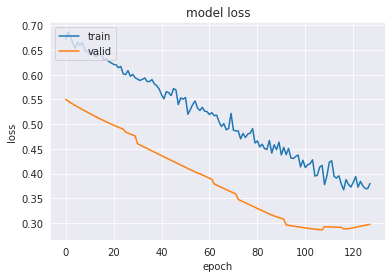

In [23]:
(history_list, 

#scores_valid_list,
scores_test_list, 

#function_values_valid_list, 
function_values_test_list, 

#polynomial_dict_valid_list,
polynomial_dict_test_list,

#distrib_dict_valid_list,
distrib_dict_test_list,

model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [28]:
poly_optimize = tf.constant([float(i) for i in range(interpretation_net_output_shape)])

if interpretation_net_output_monomials != None:
    poly_optimize_coeffs = poly_optimize[:interpretation_net_output_monomials]

    poly_optimize_identifiers_list = []
    for i in range(interpretation_net_output_monomials):
        poly_optimize_identifiers = tf.math.softmax(poly_optimize[sparsity*i+interpretation_net_output_monomials:sparsity*(i+1)+interpretation_net_output_monomials])
        poly_optimize_identifiers_list.append(poly_optimize_identifiers)
    poly_optimize_identifiers_list = tf.keras.backend.flatten(poly_optimize_identifiers_list)
    poly_optimize = tf.concat([poly_optimize_coeffs, poly_optimize_identifiers_list], axis=0)


In [29]:
poly_optimize

<tf.Tensor: shape=(21,), dtype=float32, numpy=
array([0.        , 1.        , 2.        , 0.00426978, 0.01160646,
       0.03154963, 0.08576079, 0.233122  , 0.6336913 , 0.00426978,
       0.01160646, 0.03154963, 0.08576079, 0.233122  , 0.6336913 ,
       0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.233122  ,
       0.6336913 ], dtype=float32)>

In [30]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [31]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 91)]         0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          47104       input[0][0]                      
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
hidden2_1024 (Dense)            (None, 1024)         525312      dropout1_0.25[0][0]              
______________________________________________________________________________________________

In [32]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [33]:
scores_test_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
lambda_preds_VS_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.006,0.009,0.071,0.995,0.029,0.096,0.008,0.343,0.344,0.826,0.828
lambda_preds_VS_lstsq_lambda_pred_polynomials,NaN,NaN,NaN,NaN,NaN,0.004,0.005,0.022,0.998,0.020,0.038,0.005,0.343,0.343,0.826,0.826
lambda_preds_VS_lstsq_target_polynomials,NaN,NaN,NaN,NaN,NaN,0.006,0.009,0.071,0.995,0.029,0.096,0.008,0.343,0.344,0.826,0.828
lambda_preds_VS_inet_polynomials,NaN,NaN,NaN,NaN,NaN,0.483,0.524,4.518,-5.435,1.943,1.460,0.218,0.343,0.270,0.826,0.382
lambda_preds_VS_per_network_polynomials,NaN,NaN,NaN,NaN,NaN,0.025,0.040,0.150,0.934,0.122,0.600,0.038,0.343,0.336,0.826,0.834
target_polynomials_VS_lstsq_lambda_pred_polynomials,2.916,7.643,15.644,0.300,0.000,0.005,0.007,0.021,0.997,0.025,0.103,0.006,0.344,0.343,0.828,0.826
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.344,0.344,0.828,0.828
target_polynomials_VS_inet_polynomials,0.444,0.554,1.485,0.133,0.000,0.483,0.524,2.025,-5.394,1.939,1.474,0.218,0.344,0.270,0.828,0.382
target_polynomials_VS_per_network_polynomials,1.089,1.549,2.325,0.100,0.000,0.025,0.038,0.116,0.937,0.123,0.623,0.036,0.344,0.336,0.828,0.834
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials,2.916,7.643,0.914,0.300,0.000,0.005,0.007,0.059,0.997,0.025,0.087,0.006,0.343,0.344,0.826,0.828


In [34]:
distrib_dict_test_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9
lambda_preds_VS_target_polynomials,0.003,0.006,0.003,0.008,0.001,0.002,0.001,0.018,0.005,0.015
lambda_preds_VS_lstsq_lambda_pred_polynomials,0.001,0.005,0.002,0.007,0.001,0.001,0.001,0.015,0.002,0.006
lambda_preds_VS_lstsq_target_polynomials,0.003,0.006,0.003,0.008,0.001,0.002,0.001,0.018,0.005,0.015
lambda_preds_VS_inet_polynomials,0.274,1.002,0.256,0.233,0.177,0.400,0.084,0.398,1.031,0.976
lambda_preds_VS_per_network_polynomials,0.021,0.007,0.006,0.039,0.013,0.022,0.012,0.041,0.070,0.023
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.003,0.003,0.002,0.004,0.000,0.001,0.001,0.018,0.005,0.015
target_polynomials_VS_lstsq_target_polynomials,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
target_polynomials_VS_inet_polynomials,0.274,1.000,0.254,0.237,0.177,0.400,0.083,0.393,1.033,0.982
target_polynomials_VS_per_network_polynomials,0.024,0.005,0.006,0.036,0.013,0.022,0.013,0.043,0.068,0.018
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials,0.003,0.003,0.002,0.004,0.000,0.001,0.001,0.018,0.005,0.015


In [35]:
distrib_dict_test_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9
lambda_preds_VS_target_polynomials,0.995,0.999,1.000,0.999,1.000,1.000,1.000,0.958,0.999,0.998
lambda_preds_VS_lstsq_lambda_pred_polynomials,1.000,1.000,1.000,0.999,1.000,1.000,1.000,0.983,1.000,1.000
lambda_preds_VS_lstsq_target_polynomials,0.995,0.999,1.000,0.999,1.000,1.000,1.000,0.958,0.999,0.998
lambda_preds_VS_inet_polynomials,-12.702,-11.359,0.228,0.540,0.563,0.422,0.317,-9.616,-18.619,-4.122
lambda_preds_VS_per_network_polynomials,0.869,0.999,0.999,0.973,0.997,0.999,0.966,0.810,0.729,0.996
target_polynomials_VS_lstsq_lambda_pred_polynomials,0.995,1.000,1.000,1.000,1.000,1.000,1.000,0.975,0.999,0.998
target_polynomials_VS_lstsq_target_polynomials,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
target_polynomials_VS_inet_polynomials,-12.316,-11.361,0.233,0.532,0.562,0.422,0.320,-9.236,-18.955,-4.143
target_polynomials_VS_per_network_polynomials,0.856,0.999,0.999,0.972,0.997,0.999,0.966,0.848,0.735,0.998
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials,0.995,1.000,1.000,1.000,1.000,1.000,1.000,0.975,0.999,0.998


In [36]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_min]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-9.236228225283003


1.06925976276398*a**1.0 + 0.242097929120064*a**3.0

In [37]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['lstsq_lambda_pred_polynomials_VS_inet_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-9.524909271748298


-1.78843641147776*a**1.0 + 9.95448810485444*a**2.0 - 30.431270664988*a**3.0 + 36.6444555238346*a**4.0 - 14.2958014665591*a**5.0 + 0.661004729084909

In [38]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.4362904504532*a**1.0 - 0.763670344756687*a**2.0 + 0.393474330728301*a**3.0 + 0.257885693559768*a**4.0 + 0.754944027054106*a**5.0 + 0.628936965177872

In [39]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
polynomial_inet = polynomial_dict_test_list[-1]['inet_polynomials'][index_max]

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

0.42196244464987076


-1.18992510437965*a**3.0

In [40]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.9999982427255317


-0.142331213301042*a**1.0 - 0.922485023947303*a**2.0 - 0.955582087954151*a**3.0 - 0.672582954584668*a**4.0 + 0.153003994989016*a**5.0 + 0.0453943005091653

In [41]:
index_max = int(np.argmax(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_target_polynomials']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.144917963282901*a**1.0 - 0.94916174651181*a**2.0 - 0.784217146013391*a**3.0 - 0.937141628626532*a**4.0 + 0.272820822527561*a**5.0 + 0.0454656587639881

In [42]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -5.394212236090517 (10 Samples)
Mean (only positive): 0.4137845933669101 (5 Samples)


In [43]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9966786608325974 (10 Samples)
Mean (only positive): 0.9966786608325974 (10 Samples)


<AxesSubplot:xlabel='target_polynomials_VS_inet_polynomials', ylabel='Count'>

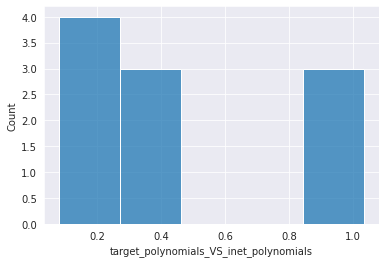

In [44]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50])


<AxesSubplot:xlabel='target_polynomials_VS_lstsq_lambda_pred_polynomials', ylabel='Count'>

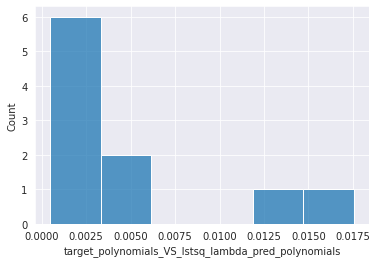

In [45]:
sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50])


[(-30.0, 1.0)]

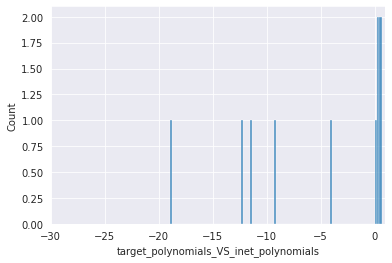

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

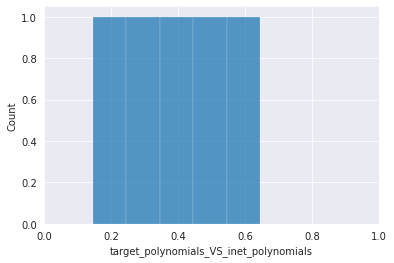

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_inet_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

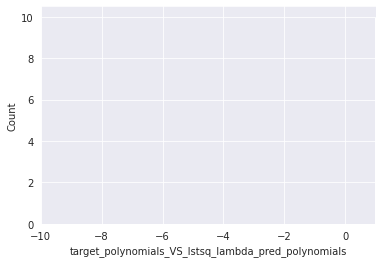

In [48]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

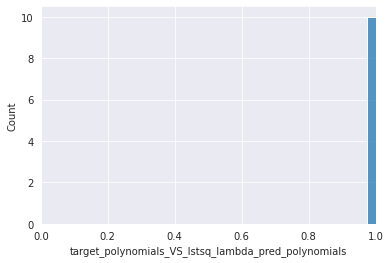

In [49]:
p = sns.histplot(distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['R2'].loc['target_polynomials_VS_lstsq_lambda_pred_polynomials'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

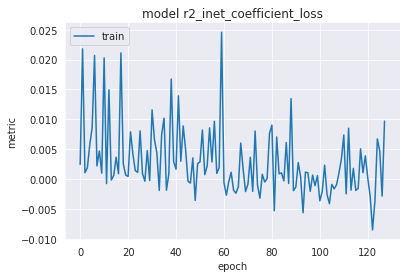

In [50]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


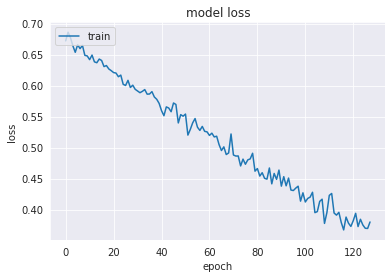

In [51]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

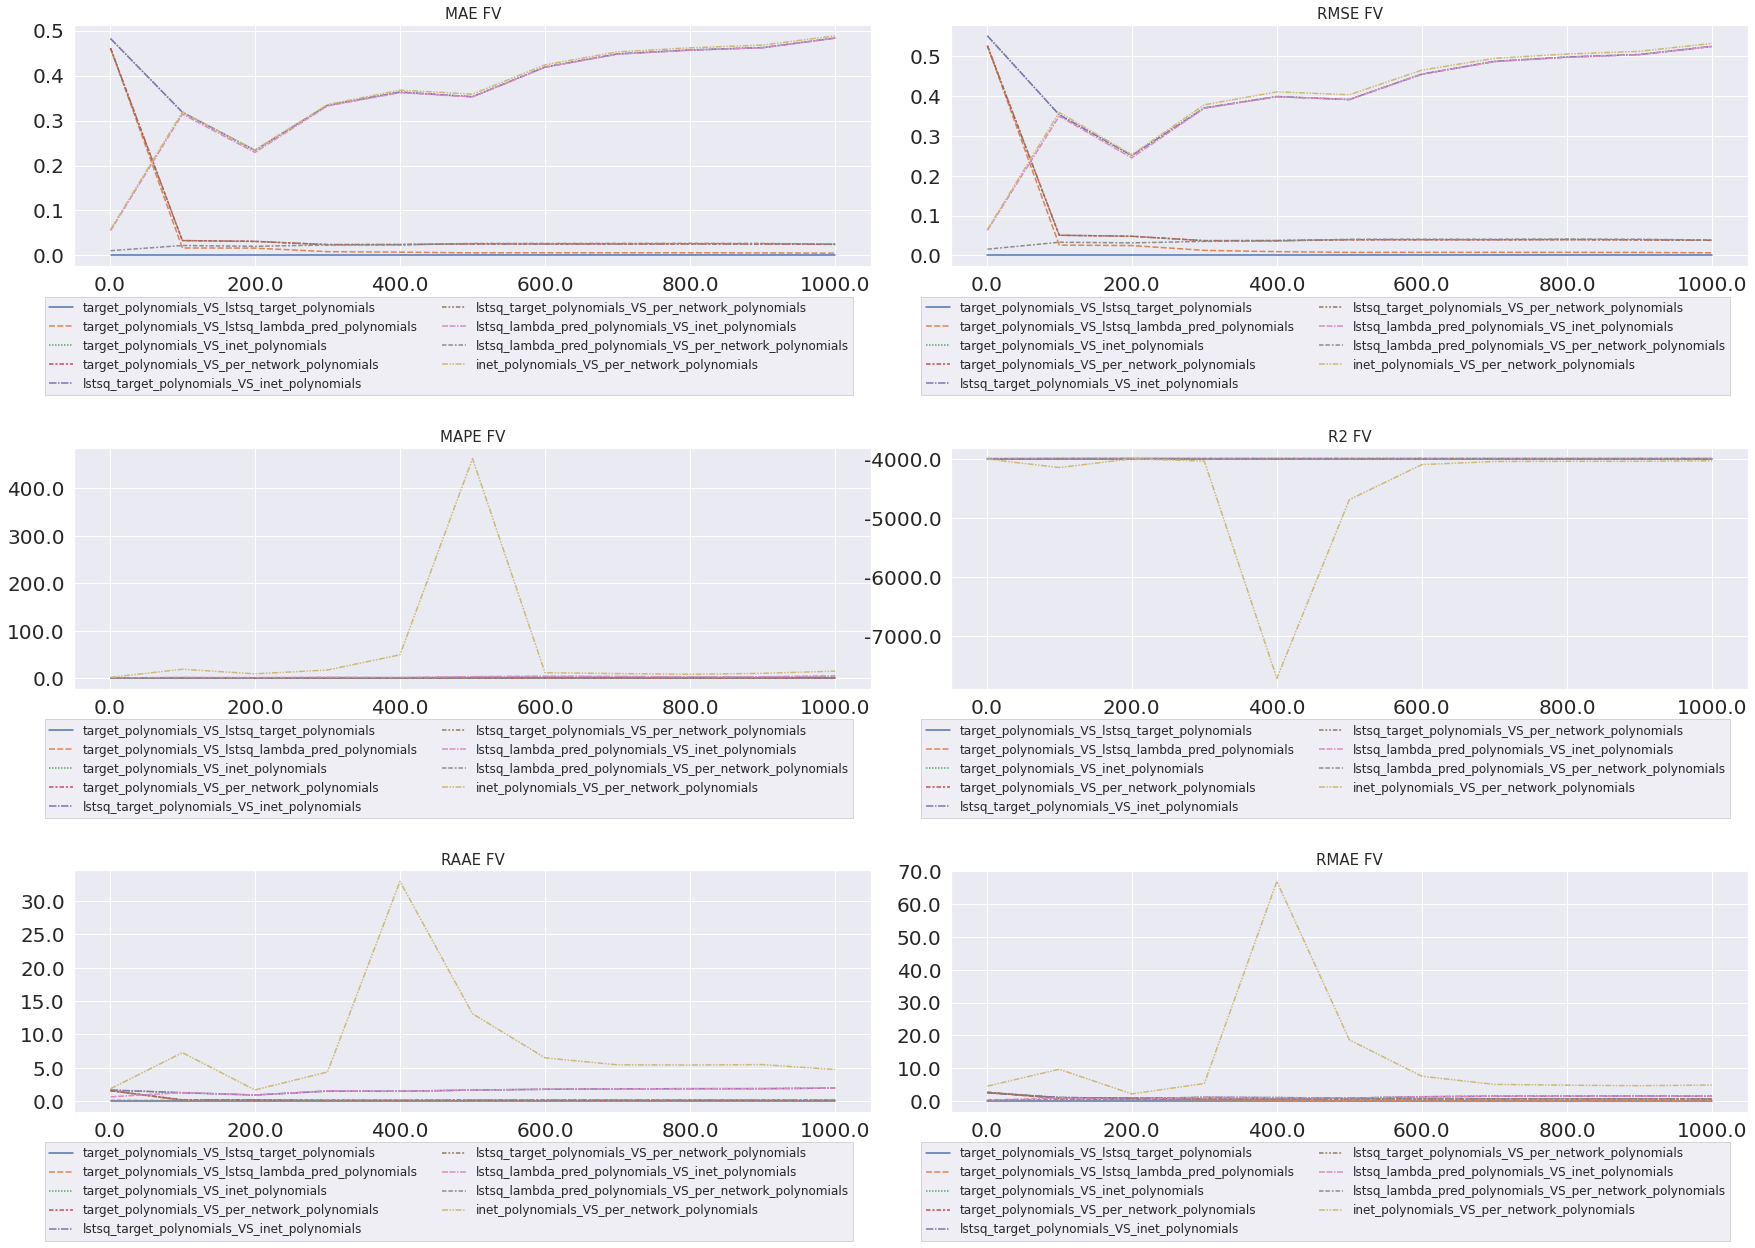

In [138]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

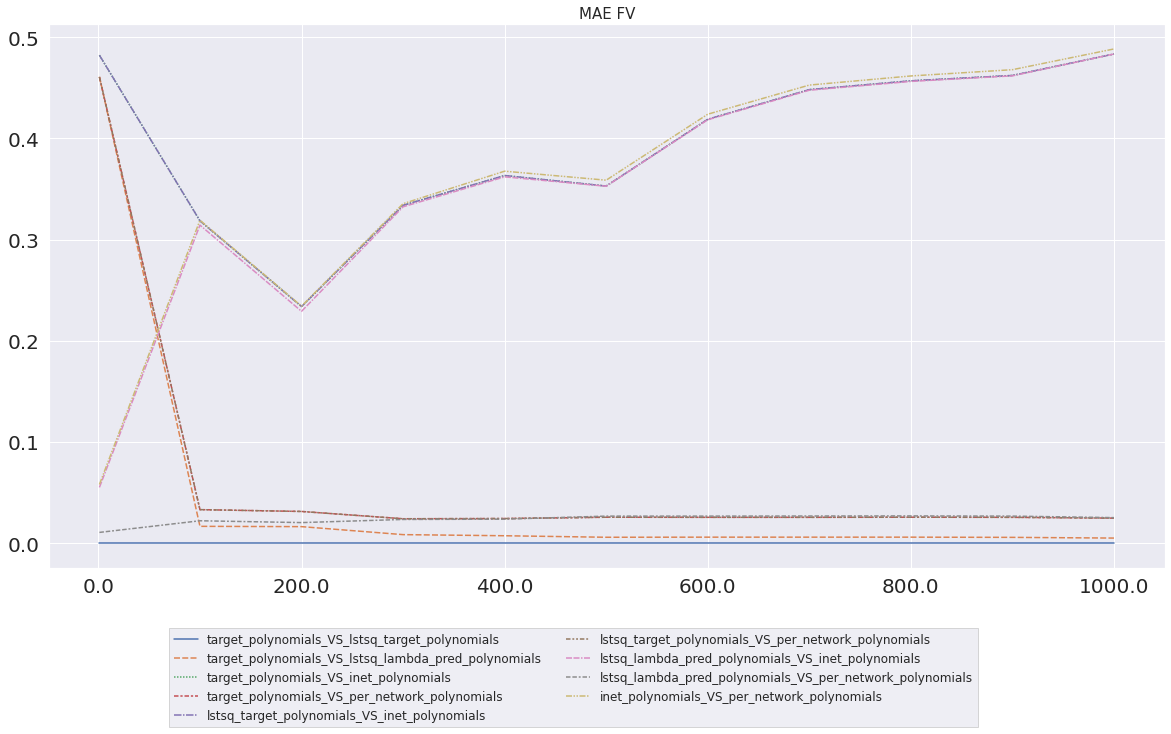

In [142]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

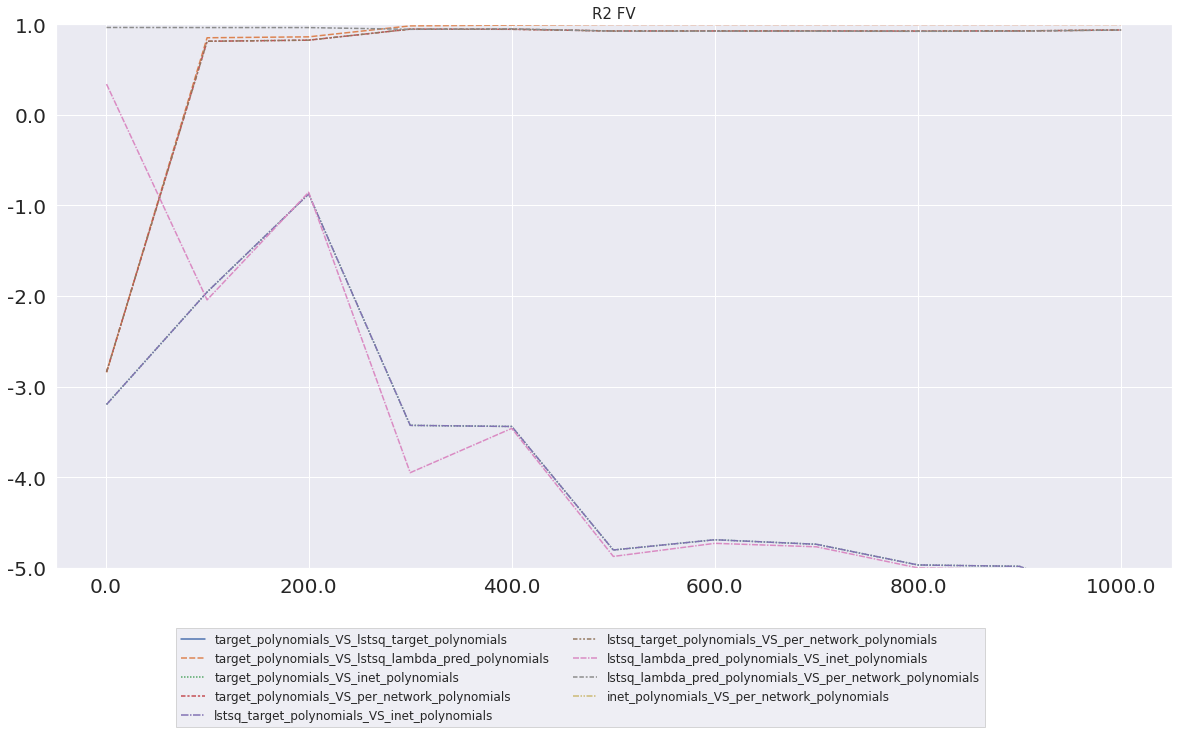

In [143]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [144]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']

for key in polynomial_dict_test_list[-1].keys():
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
    else:
        display(polynomial_dict_test_list[-1][key][index])


lstsq_lambda_pred_polynomials


0.501*a**1.0 - 0.3453*a**2.0 - 0.0531*a**3.0 + 0.3301*a**4.0 + 0.0225*a**5.0 + 0.3449

lstsq_target_polynomials


0.5232*a**1.0 - 0.5247*a**2.0 + 0.4564*a**3.0 - 0.2644*a**4.0 + 0.2646*a**5.0 + 0.3443

target_polynomials


0.5232*a**1.0 - 0.5247*a**2.0 + 0.4564*a**3.0 - 0.2644*a**4.0 + 0.2646*a**5.0 + 0.3443

inet_polynomials


0.143299996852875*a**3.0 + 0.357800006866455*a**4.0 + 0.350199997425079

symbolic_regression_functions


0.36*x + 0.35

per_network_polynomials


0.358900010585785*a**1.0 + 0.353699989616871

In [145]:
function_values_test_list[-1].keys()

dict_keys(['lambda_preds', 'target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_target_polynomials', 'inet_polynomials', 'per_network_polynomials'])

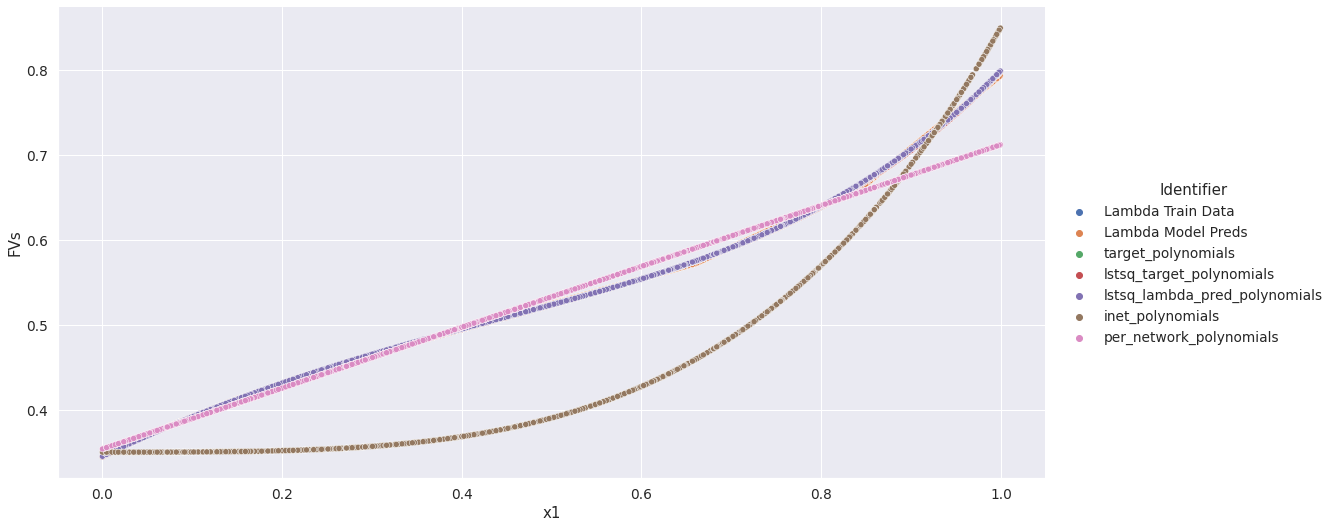

In [146]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

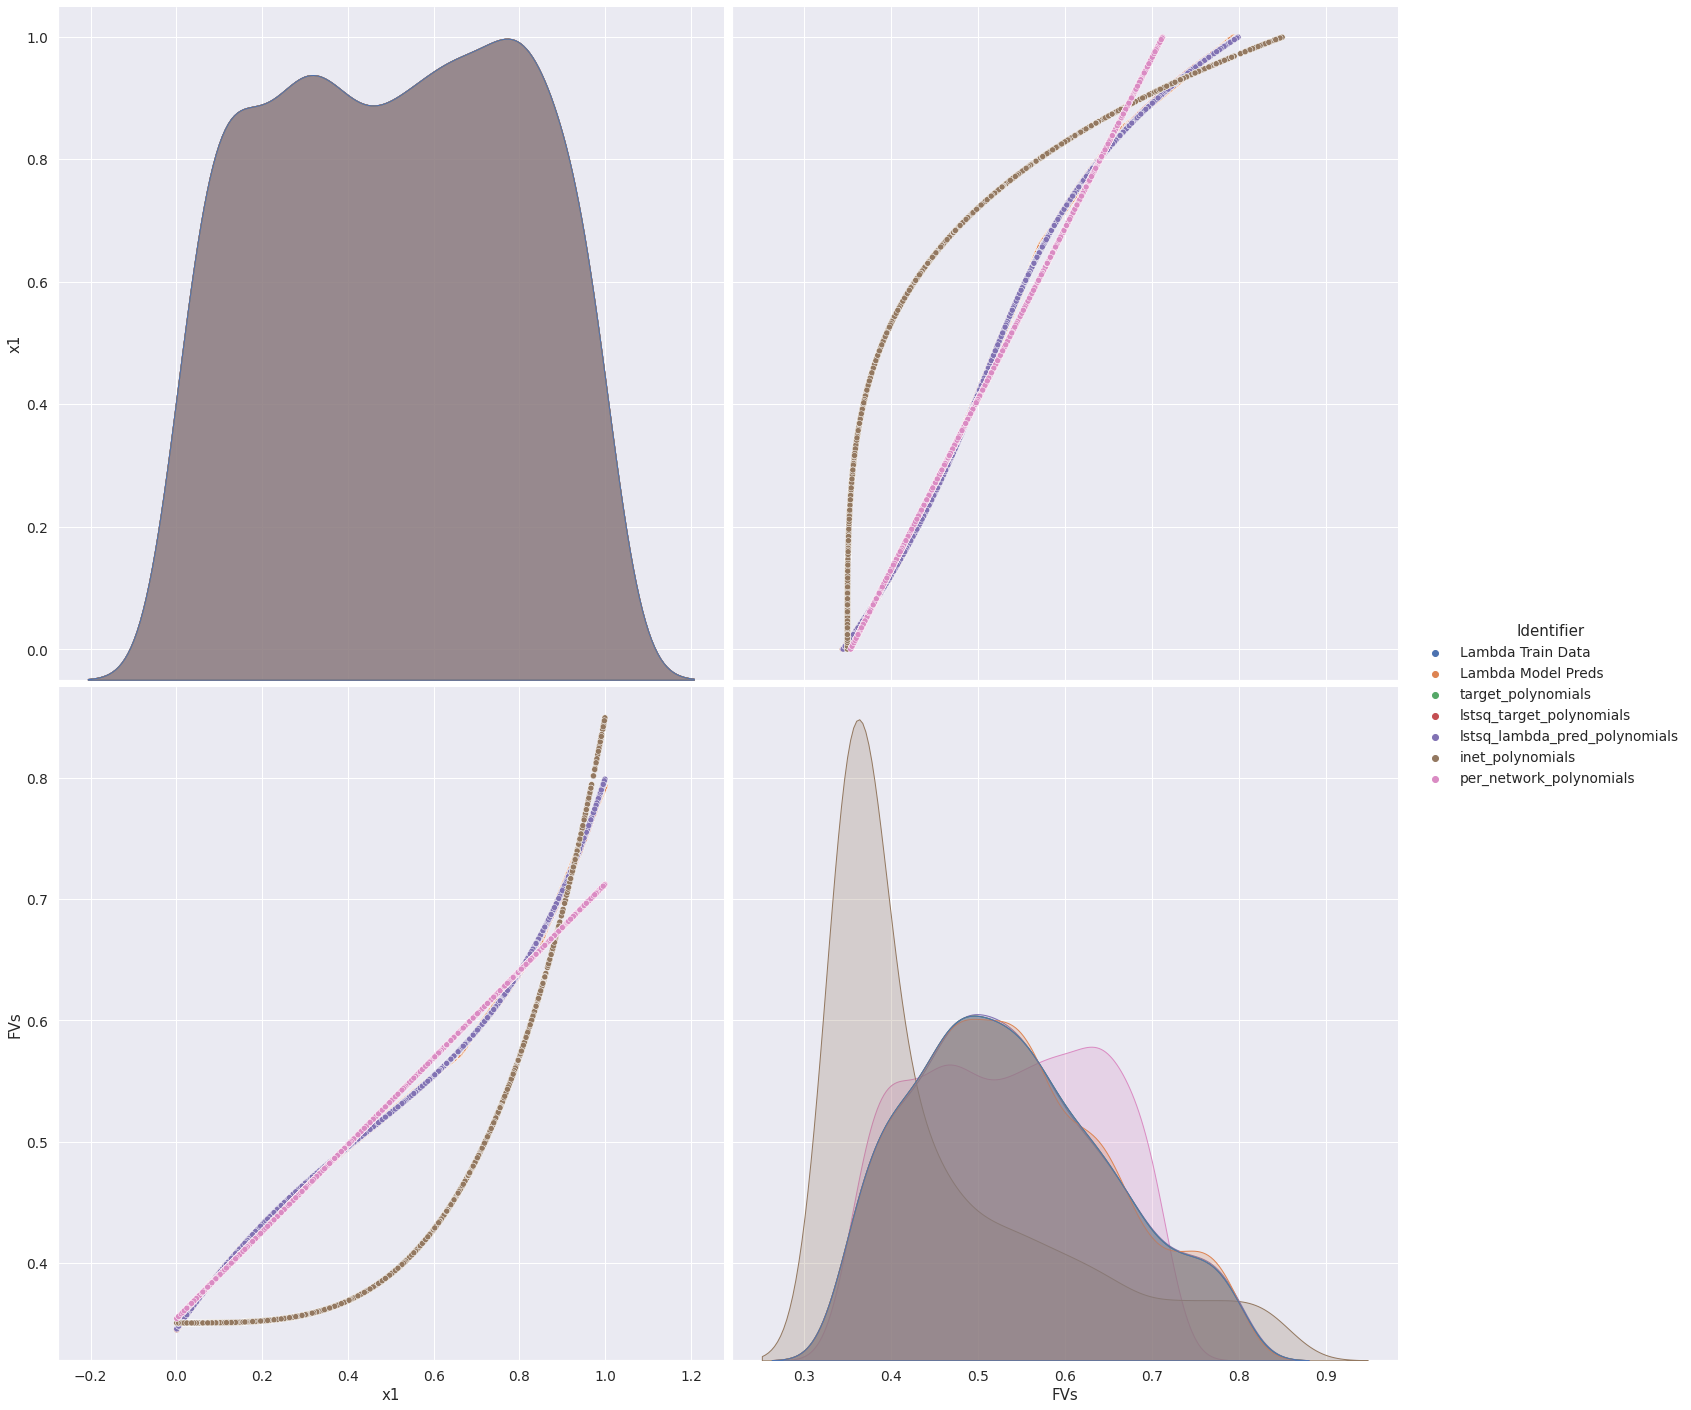

In [147]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

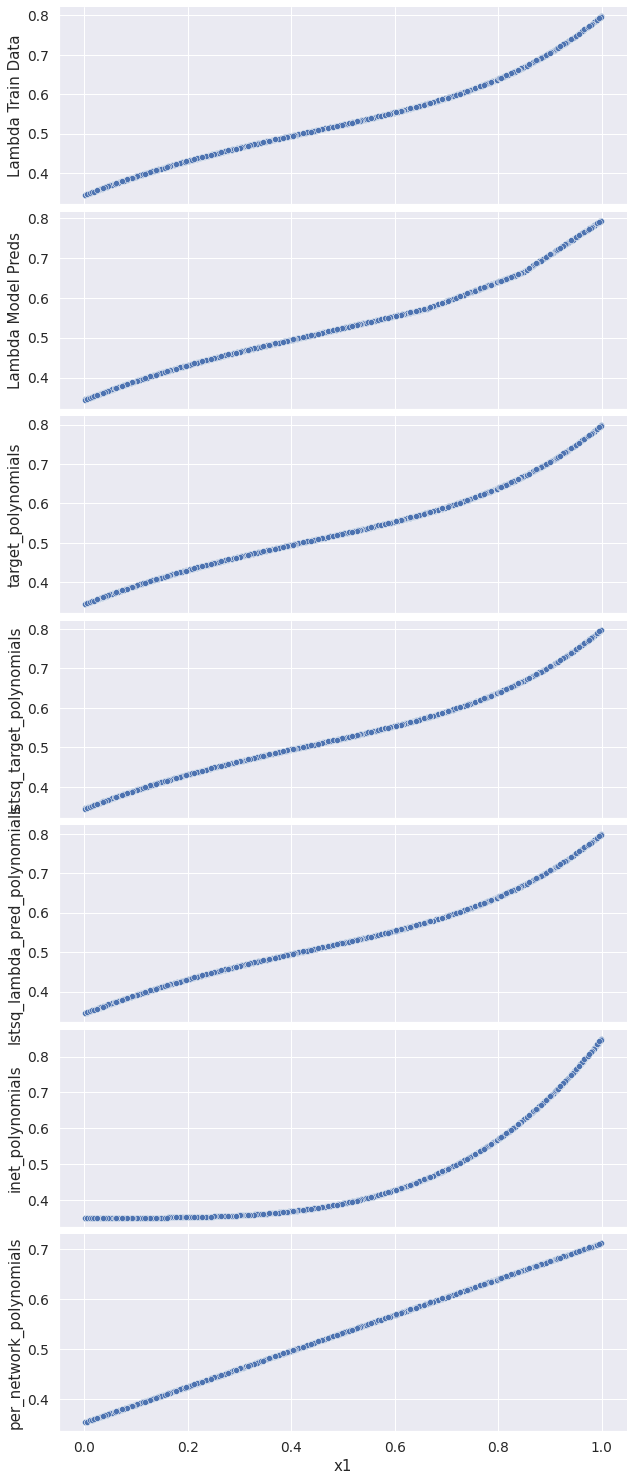

In [148]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [149]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 